# Task per forecasting

1. Preparazione e Costruzione della Serie Temporale

- Creazione della variabile temporale combinando Year, Month e day.
- Conversione in datetime e ordinamento del dataset.
- Impostazione della colonna temporale come indice del DataFrame.
- Aggregazione dei dati con frequenza costante tramite resample (es. mensile MS).
- Gestione dei eventuali valori mancanti mediante interpolazione o forward-fill.
- Impostazione esplicita della frequenza dell’indice temporale.

**Obiettivo**: ottenere una serie regolare, completa e pronta per il modeling.

2. Analisi Esplorativa della Serie
- Visualizzazione della serie temporale per identificare pattern, outlier e comportamenti anomali.
- Applicazione della decomposizione stagionale (seasonal_decompose) per separare:

    - Trend di lungo periodo
    - Stagionalità
    - Componente residua

- Identificazione preliminare della presenza o assenza di stagionalità o trend marcati.

Questa fase permette di scegliere la famiglia di modelli più adatta (ARIMA vs SARIMA).

3. Verifica della Stazionarietà

- La stazionarietà è un requisito fondamentale per i modelli ARIMA.
- Applicazione dell’Augmented Dickey-Fuller Test (ADF).
- Interpretazione:
    - p-value < 0.05: la serie è stazionaria → d = 0
    - p-value ≥ 0.05: la serie NON è stazionaria → applicare differenziazione

Se la serie viene differenziata, ripetere l’ADF fino alla stazionarietà.

L’obiettivo di questa fase è determinare il parametro d del modello ARIMA(p,d,q).

4. Analisi delle Autocorrelazioni (ACF e PACF)

- Calcolo della autocorrelazione semplice (ACF) e parziale (PACF).
- Interpretazione dei lag significativi:
    - PACF → stima preliminare di p (componente AR)
    - ACF → stima preliminare di q (componente MA)

**Se la serie è stata differenziata, i grafici vanno interpretati sulla serie differenziata.**

Questa fase restringe il set dei modelli ARIMA candidati.

5. Modellazione: ARIMA / SARIMA

- Costruzione di modelli ARIMA(p,d,q) sulla base dello studio di ACF e PACF.
- In presenza di stagionalità periodica, utilizzo dei modelli SARIMA(p,d,q)(P,D,Q,s).
- Confronto dei modelli tramite:
    - AIC (criterio di Akaike) → preferire valori più bassi 
    - Significatività dei coefficienti
    - Parsimony (modelli più semplici se comparabili)

Questa fase porta alla selezione del set di modelli più appropriati per il forecasting.

6. Diagnosi dei Residui

- Una condizione essenziale affinché il modello sia valido:
- I residui devono comportarsi come rumore bianco:
- Media prossima allo zero
- Assenza di autocorrelazione (Ljung-Box test)
- Varianza costante
- Distribuzione approssimativamente normale

Se i residui mostrano pattern o autocorrelazione residua → il modello è da rivedere.

7. Suddivisione Train/Test (Time-Based)

- Divisione temporale della serie in:
- Train: tutte le osservazioni tranne gli ultimi N mesi
- Test: gli ultimi N mesi (es. 12 mesi)
- Addestramento del modello sul train set.
- Previsione (one-step-ahead o multi-step) sul test set.
- Calcolo delle metriche:
    - MAE
    - RMSE
    - MAPE

Questa fase valuta la capacità del modello di generalizzare sui dati non visti.

8. Forecast Finale

- Addestramento del modello scelto sull’intera serie storica.
- Previsione sui prossimi k periodi (es. 12 o 24 mesi).
- Calcolo degli intervalli di confidenza con get_forecast():
    - previsione media
    - banda di confidenza 95%

- Visualizzazione finale con:
    - serie storica
    - forecast
    - intervalli di confidenza

9. Selezione del Modello Definitivo

- Il modello viene scelto in base a:
    - AIC più basso
    - analisi dei residui
    - stabilità del forecast
    - interpretabilità
    - performance su train/test

Il modello finale deve essere giustificato sulla base della struttura della serie e dei test statistici condotti.

In [1]:
# Dependencies import

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

In [2]:
df_train = pd.read_csv("data/DailyDelhiClimateTrain.csv")
df_test = pd.read_csv("data/DailyDelhiClimateTest.csv")

for df_ in (df_train, df_test):
    df_["date"] = pd.to_datetime(df_["date"])

df_train = df_train.set_index("date").sort_index().asfreq("D")
df_test = df_test.set_index("date").sort_index().asfreq("D")

df_all = pd.concat([df_train, df_test])

print(f"Train shape {df_train.shape}, Test shape {df_test.shape}")
print(f"Combined shape {df_all.shape}")
print(f"Date range: {df_all.index.min()} to {df_all.index.max()}")
df_all.head()

Train shape (1462, 4), Test shape (114, 4)
Combined shape (1576, 4)
Date range: 2013-01-01 00:00:00 to 2017-04-24 00:00:00


,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


## Time Series creation

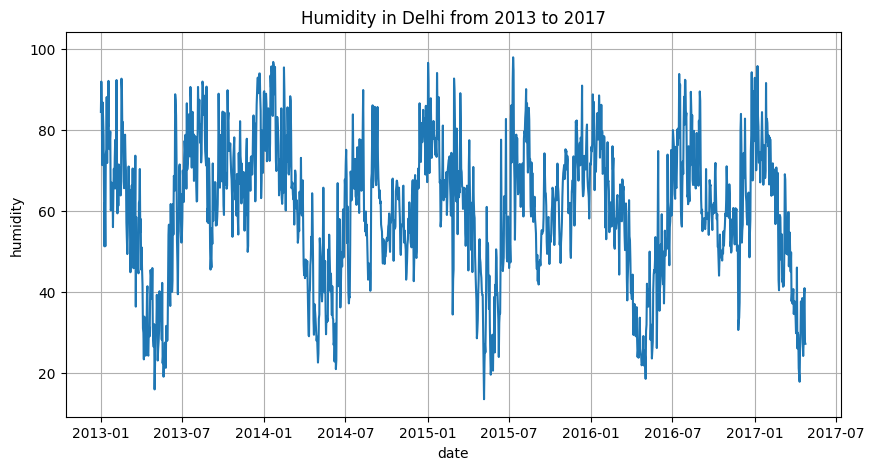

Series date range: 2013-01-01 00:00:00 to 2017-04-24 00:00:00


,humidity
date,
2013-01-01,84.500000
2013-01-02,92.000000
2013-01-03,87.000000
2013-01-04,71.333333
2013-01-05,86.833333


In [3]:
# Humidity Time Series
series = df_all.drop(columns=["wind_speed", "meanpressure", "meantemp"])

# Sort by index
series = series.sort_index()  

# Plot
sns.lineplot(x=series.index, y="humidity", data=series)
plt.title("Humidity in Delhi from 2013 to 2017")
plt.show()

print(f"Series date range: {series.index.min()} to {series.index.max()}")
series.head()

### Series decomposition

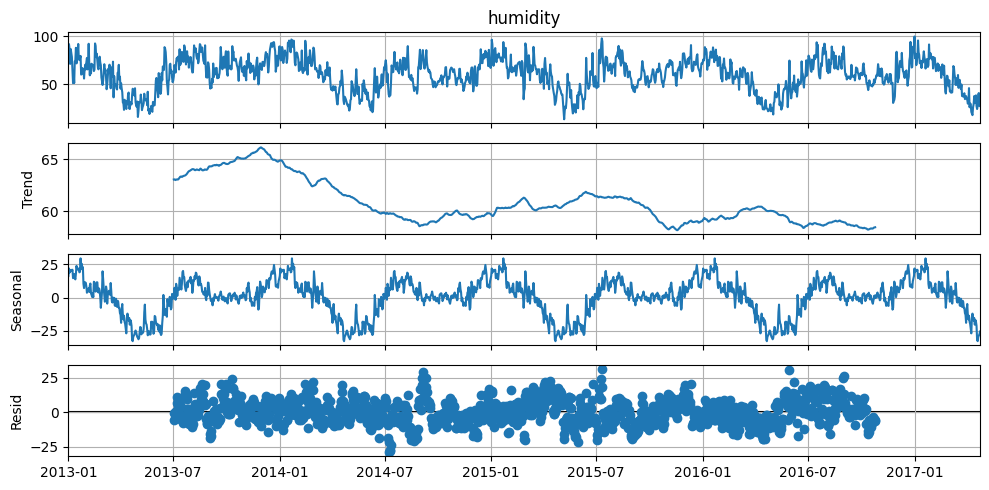

In [4]:
seasonal_decompose(series["humidity"], period=365).plot()
plt.show()

## Stationarity

In [5]:
def adf_test(series):
    print(f"=== ADF test ===")
    result = adfuller(series.dropna())
    print("ADF Statistics", result[0])
    print("p-value:", result[1])
    
    if result[1] < 0.05:
        print("=> Serie stazionaria (rifiutiamo H0)")
    else:
        print("=> Serie NON stazionaria (non rifiutiamo H0)")
  

adf_test(series["humidity"])

=== ADF test ===
ADF Statistics -3.62894215938588
p-value: 0.00523122148555798
=> Serie stazionaria (rifiutiamo H0)


### PACF & ACF
Identify p,q,P,D,Q

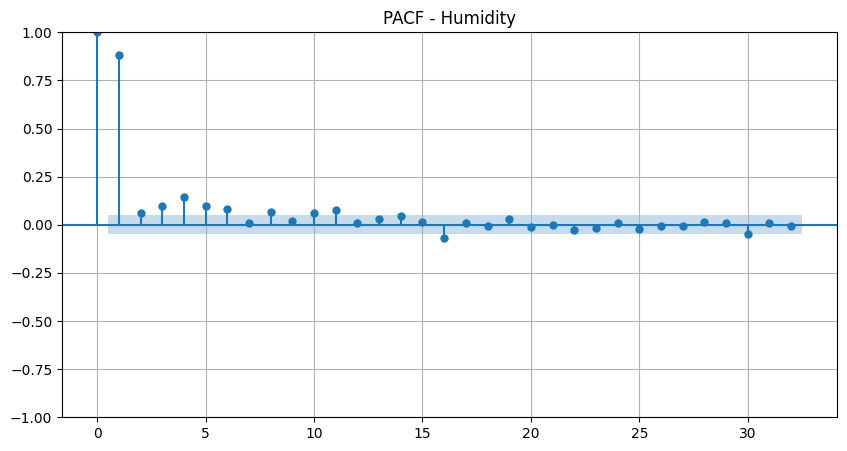

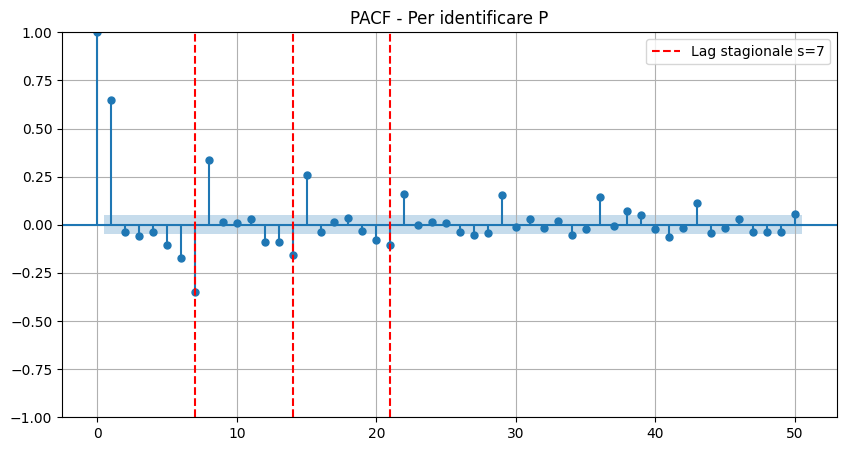

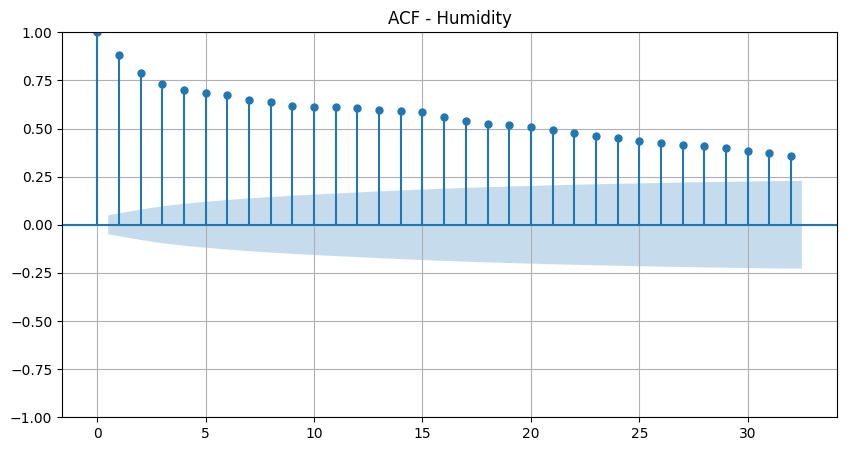

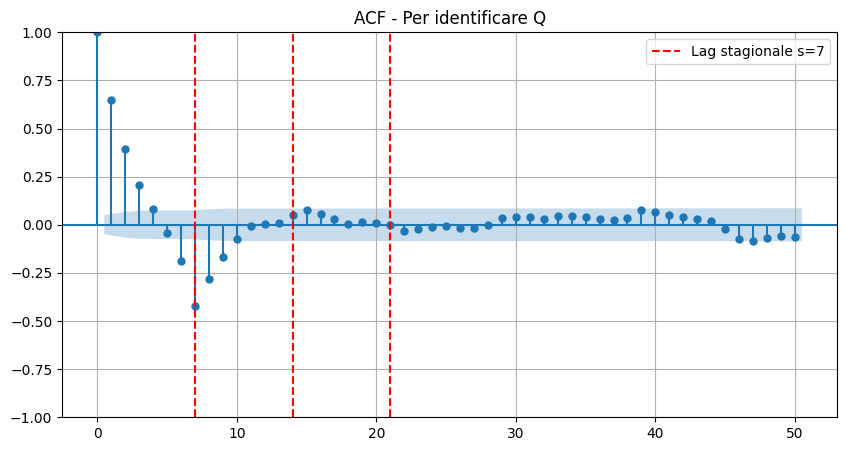

In [7]:
series_seasonal_diff = series["humidity"].diff(7).dropna()

plot_pacf(series["humidity"])
plt.title("PACF - Humidity")


plot_pacf(series_seasonal_diff, lags=50)
plt.title("PACF - Per identificare P")
plt.axvline(x=7, color='r', linestyle='--', label='Lag stagionale s=7')
plt.axvline(x=14, color='r', linestyle='--')
plt.axvline(x=21, color='r', linestyle='--')
plt.legend()
plt.show()


plot_acf(series["humidity"])
plt.title("ACF - Humidity")
plt.show()

plot_acf(series_seasonal_diff, lags=50)
plt.title("ACF - Per identificare Q")
plt.axvline(x=7, color='r', linestyle='--', label='Lag stagionale s=7')
plt.axvline(x=14, color='r', linestyle='--')
plt.axvline(x=21, color='r', linestyle='--')
plt.legend()
plt.show()

## SARIMAX Model

In [7]:
#MEANPRESSURE REMOVED BEACUSA INSIGNIFICANT 0.98 |P|
exog_train = df_train[["meantemp", "wind_speed"]]
exog_test = df_test[["meantemp", "wind_speed"]]

order = (1, 0, 1)
seasonal_order = (0, 1, 1, 7)

model = SARIMAX(
    df_train["humidity"],
    exog=exog_train,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fit = model.fit(disp=False)
print(sarima_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                          humidity   No. Observations:                 1462
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 7)   Log Likelihood               -4644.401
Date:                           Sun, 16 Nov 2025   AIC                           9300.801
Time:                                   15:42:53   BIC                           9332.461
Sample:                               01-01-2013   HQIC                          9312.617
                                    - 01-01-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
meantemp      -3.1187      0.071    -43.817      0.000      -3.258      -2.979
wind_speed    -0.2930      0.030     -9.864

### Residuals

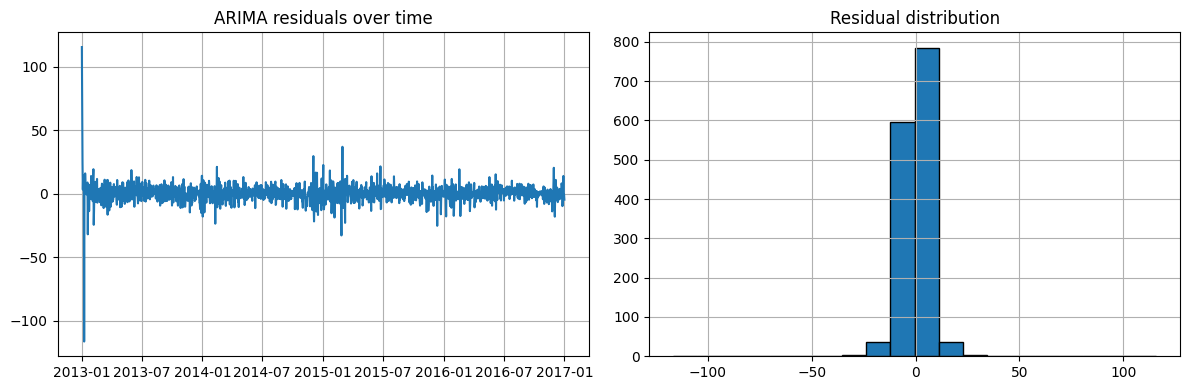

<Figure size 1000x500 with 0 Axes>

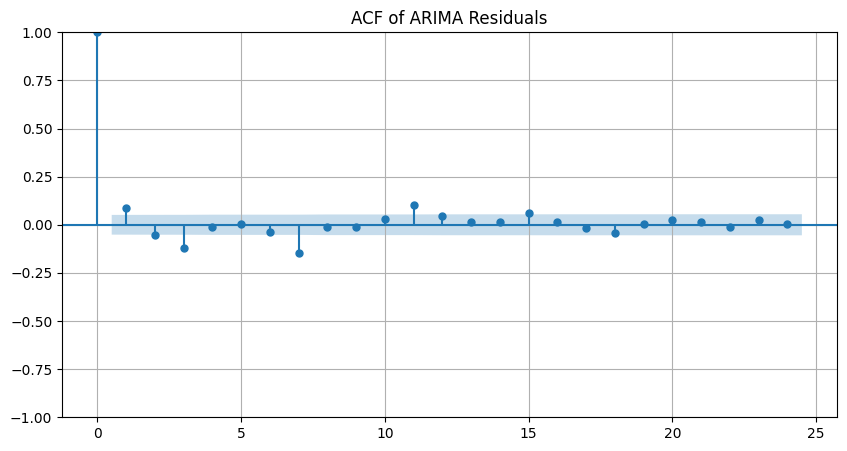

In [8]:
residuals = sarima_fit.resid
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(residuals)
axes[0].set_title("ARIMA residuals over time")

axes[1].hist(residuals, bins=20, edgecolor="black")
axes[1].set_title("Residual distribution")

plt.tight_layout()
plt.show()

# ACF dei residui
plt.figure()
plot_acf(residuals.dropna(), lags=24)
plt.title("ACF of ARIMA Residuals")
plt.show()

## Evaluation on Test dataset

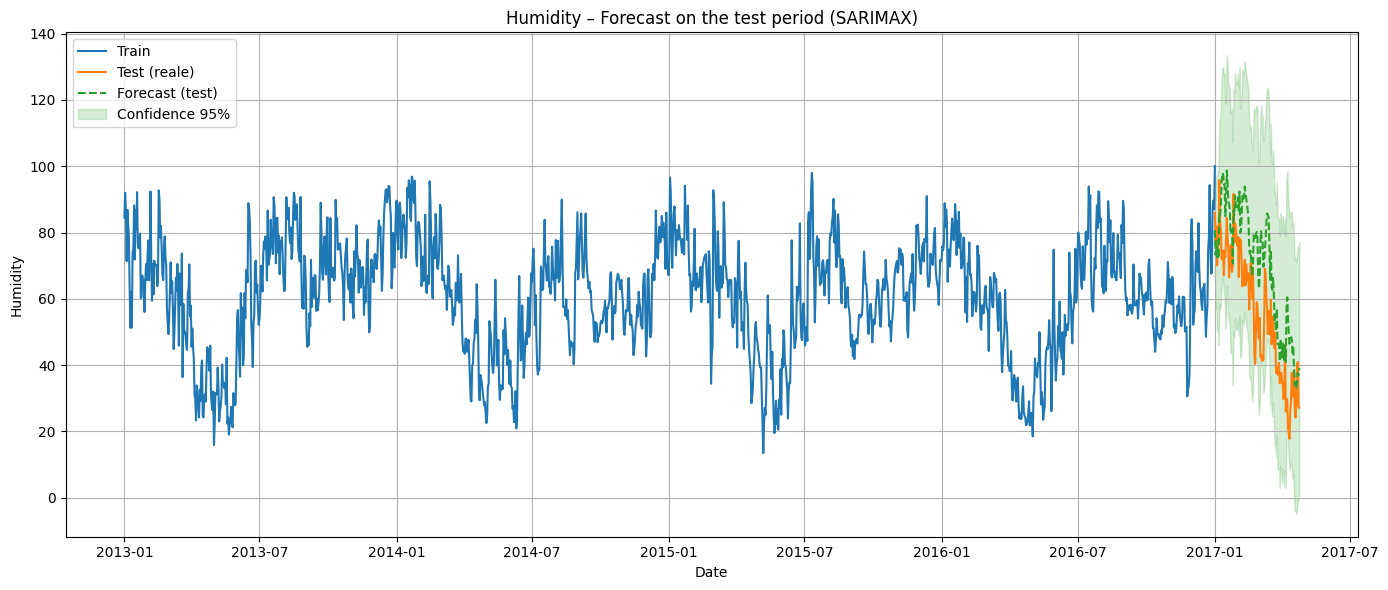

In [9]:
# Number of steps to forecast
steps = len(exog_test)

pred_obj = sarima_fit.get_forecast(steps=steps, exog=exog_test)
pred_mean = pred_obj.predicted_mean
pred_ci = pred_obj.conf_int()

pred_mean.index = df_test.index
pred_ci.index = df_test.index

plt.figure(figsize=(14, 6))

# Train data
plt.plot(df_train.index, df_train["humidity"], label="Train", color="tab:blue")

# Actual data (test)
plt.plot(df_test.index, df_test["humidity"],
         label="Test (reale)", color="tab:orange")

# Forecast
plt.plot(pred_mean.index, pred_mean, label="Forecast (test)",
         color="tab:green", linestyle="--")

# Confidence band
plt.fill_between(
    pred_ci.index,
    pred_ci.iloc[:, 0],
    pred_ci.iloc[:, 1],
    color="tab:green",
    alpha=0.2,
    label="Confidence 95%"
)

plt.title("Humidity – Forecast on the test period (SARIMAX)")
plt.xlabel("Date")
plt.ylabel("Humidity")
plt.legend()
plt.tight_layout()
plt.show()

## Evaluation

1. Mean Absolute Percentage Error (MAPE)
2. Mean Error (ME)
3. Mean Absolute Error (MAE)
4. Mean Percentage Error (MPE)
5. Root Mean Squared Error (RMSE)
6. Correlation between the Actual and the Forecast (corr)
7. Min-Max Error (minmax)


In [10]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error

def forecast_evaluation(test, forecast):
    test = np.array(test)
    forecast = np.array(forecast)
    
    mape = mean_absolute_percentage_error(test, forecast) * 100
    me = np.mean(forecast - test)
    mae = mean_absolute_error(test, forecast)
    mpe = np.mean((forecast - test) / test)
    rmse = root_mean_squared_error(test, forecast)
    corr = np.corrcoef((forecast, test))[0, 1]
    mins = np.amin(np.hstack([forecast[:,None], 
                           test[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                           test[:,None]]), axis=1)
    minmax = 1- np.mean(mins / maxs)
    
    return({
        "MAPE": mape,
        "ME": me,
        "MAE": mae,
        "MPE": mpe,
        "RMSE": rmse,
        "CORR": corr,
        "MINMAX": minmax
    })
    

def print_metrics_df(metrics):
    df = pd.DataFrame(metrics, index=[0]).T
    df.columns = ["Value"]
    display(df.style.format("{:.4f}"))

    
metrics = forecast_evaluation(df_test["humidity"], pred_mean)
print_metrics_df(metrics)

,Value
MAPE,33.1018
ME,14.3127
MAE,15.0752
MPE,0.3203
RMSE,17.9501
CORR,0.8338
MINMAX,0.2182
